# ECG Library

## Suggested pipeline

### Load ECG images

In [4]:
import os
from PIL import Image

In [5]:
dirname = 'examples/example_images/'

In [6]:
images = os.listdir(dirname)

In [7]:
images = sorted(images, key=lambda a: int(a.split('.')[0]))

In [8]:
images

['1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png']

In [9]:
images = [Image.open(dirname + filename) for filename in images]

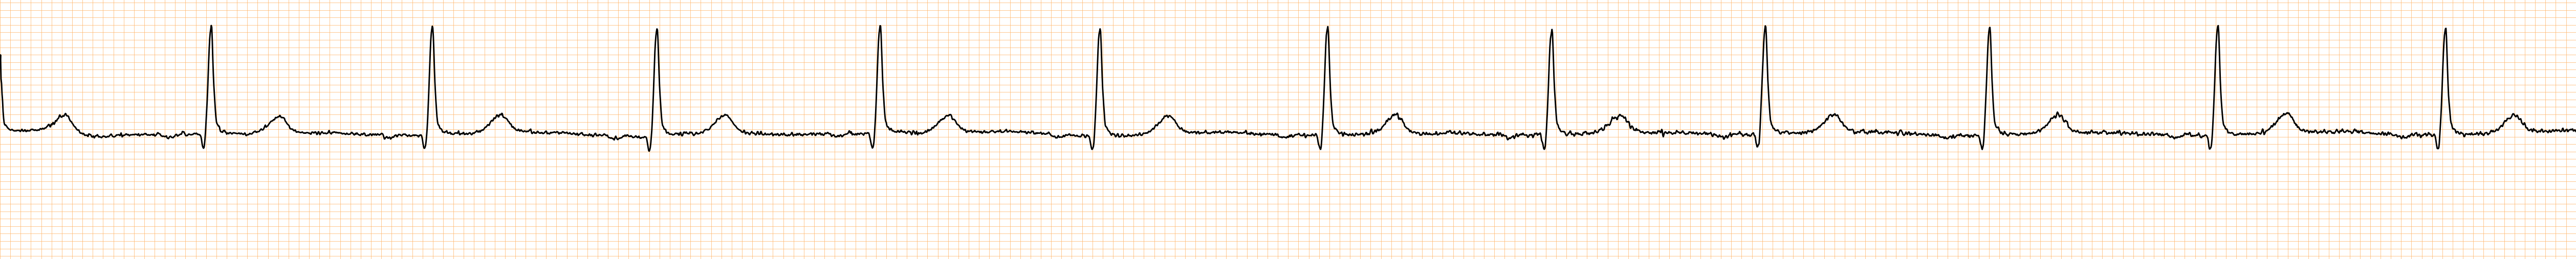

In [7]:
images[1]

### Convert images to signal

In [2]:
import ECG.api as api
import numpy as np

In [10]:
signal = [api.convert_image_to_signal(np.asarray(image)[:,:,:3]) for image in images]

### display explanations

In [11]:
def display_text_explanation(explanation:api.TextExplanation):
    print('Text explanation:', explanation.content)

def display_text_and_image_explanation(explanation:api.TextAndImageExplanation):
    print('Text explanation:', explanation.text)
    print('GradCAM visualization:')
    return explanation.image

### Get signal of all 12 ECG leads
Recommended sampling rate is 500

In [12]:
sampling_rate = 500

In [13]:
mm_per_mv = 10

In [14]:
signal = np.asarray([i / mm_per_mv for i in signal])

In [15]:
assert len(signal.shape) == 2
assert signal.shape[0] == 12

### Check whether ST-elevation is present

In [16]:
res = api.check_ST_elevation(signal, sampling_rate=sampling_rate)
print('Result:', res[0])
print('Explanation:')
display_text_explanation(res[1])

Result: ElevatedST.Abscent
Explanation:
Text explanation: ST elevation value in lead V3 (0.04126003416910934 mV) did not exceed the threshold 0.2, therefore ST elevation was not detected.


In [17]:
res = api.check_ST_elevation_with_NN(signal)
print('Result:', res[0])
print('Explanation:')
display_text_and_image_explanation(res[1])

Load model at ./ECG/NN_based_approach/Models/Conv1_ste_model.pt
Result: ElevatedST.Abscent
Explanation:
Text explanation: Significant ST elevation probability is 0.3325
GradCAM visualization:


### Evaluate risk markers

In [18]:
api.evaluate_risk_markers(signal, sampling_rate=sampling_rate)

RiskMarkers(Ste60_V3=0.04126003416910934, QTc=417, RA_V4=0.9481276953640756)

### Perform differential diagnosis

In [19]:
res = api.diagnose_with_risk_markers(signal, sampling_rate=sampling_rate)
print('Result:', res[0])
print('Explanation:')
display_text_explanation(res[1])

Result: Diagnosis.BER
Explanation:
Text explanation: Criterion value calculated as follows: (1.196 * [STE60 V3 in mm]) + (0.059 * [QTc in ms]) – (0.326 * [RA V4 in mm])) = 22.00557372177566 did not exceed the threshold 23.4, therefore the diagnosis is Benign Early Repolarization


In [20]:
res = api.check_BER_with_NN(signal)
print('Result:', res[0])
print('Explanation:')
display_text_and_image_explanation(res[1])

Load model at ./ECG/NN_based_approach/Models/Conv_ber_model.pt
Result: True
Explanation:
Text explanation: BER probability is 0.9278
GradCAM visualization:


In [21]:
res = api.check_MI_with_NN(signal)
print('Result:', res[0])
print('Explanation:')
display_text_and_image_explanation(res[1])

Load model at ./ECG/NN_based_approach/Models/Conv_mi_model.pt
Result: False
Explanation:
Text explanation: MI probability is 0.0017
GradCAM visualization:


### Check if the ECG is normal or not

In [25]:
from ECG.ecghealthcheck.enums import ECGClass

In [27]:
signal = signal[:, :4000]
signal.shape

(12, 4000)

In [29]:
res = api.check_ecg_is_normal(signal, ECGClass.ALL)
print('Result:', res[0])
display_text_explanation(res[1])

Result: True
Text explanation: The signal is ok
